In [43]:
import os
import torch
import GPUtil
from sklearn.model_selection import train_test_split

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps

# Imports de las funciones creadas para este programa
from models.non_constant_diffusivity import NonConstantDiffusivityNeuralNetwork
from utils.folders import create_folder
from utils.load_data import load_data
from trainers.train import train_loop

In [44]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'/home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data/non_linear/non_linear_few_data.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/non_linear')
MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/non_linear/model few data')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
create_folder(MODEL_RESULTS_PATH)

Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear
Folder already exists at: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/results/non_linear/model few data


In [45]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear/non_linear_few_data.pkl


In [46]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


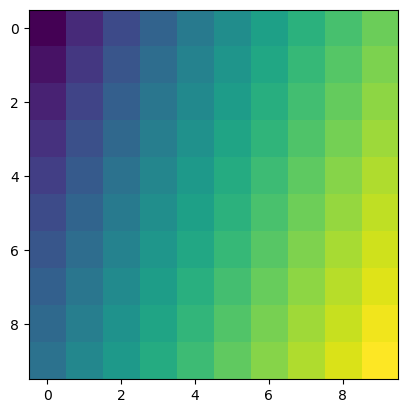

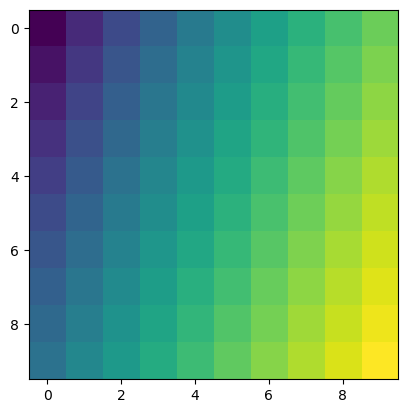

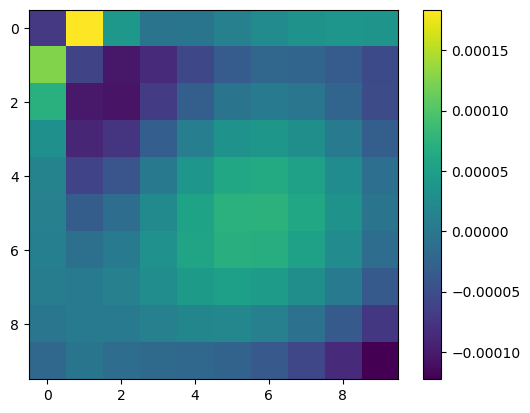

In [67]:
import numpy as np
import matplotlib.pyplot as plt

reshaped_data = y_train.values.to('cpu').detach().reshape(y_train.values.shape[0], -1)

U, S, Vh = np.linalg.svd(reshaped_data, full_matrices=False)

# Step 4: Reconstruct POD modes
# POD modes are the columns of U, singular values are S
pod_modes = U  # Each column of U is a POD mode
singular_values = S  # Singular values give the importance of each mode

# Step 5: Compute energy contribution of each mode (optional)
energy_contribution = (S**2) / np.sum(S**2)

# # Print results
# print("POD Modes Shape:", pod_modes.shape)  # Should be (100, 100), 100 modes
# print("Singular Values:", singular_values)
# print("Energy Contribution of Each Mode:", energy_contribution)


# plt.plot(singular_values)
# plt.show()
# Optionally: Reconstruct the data using only a few POD modes
# For example, reconstruct using the first 10 modes
n_modes = 10
reconstructed_data = np.dot(U[:, :n_modes], np.dot(np.diag(S[:n_modes]), Vh[:n_modes, :]))

# print("Reconstructed Data Shape:", reconstructed_data.shape)  # Should be (100, 100)

plt.imshow(y_train.values.to('cpu').detach()[0, 0])
plt.show()

plt.imshow(reconstructed_data.reshape(y_train.values.shape)[0, 0])
plt.show()

plt.imshow((y_train.values.to('cpu').detach() - reconstructed_data.reshape(y_train.values.shape))[0, 0])
plt.colorbar()
plt.show()


In [15]:
# Tratamiento de los datos para dividirlos en train y test
X_train = torch.Tensor(dataset['X_train']).unsqueeze(1)
y_train = TensOps(torch.tensor(dataset['y_train'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_train = TensOps(torch.tensor(dataset['k_train'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
f_train = TensOps(torch.tensor(dataset['f_train'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

X_val = torch.Tensor(dataset['X_val']).unsqueeze(1)
y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

X_np = X_train
y_np = y_train.values
K_np = K_train.values
f_np = f_train.values

X_train_np, X_test_np, y_train_np, y_test_np, K_train_np, K_test_np, f_train_np, f_test_np = train_test_split(X_np, y_np, K_np, f_np, test_size=0.2, random_state=42)

X_train = X_train_np.to(device)
X_test = X_test_np.to(device)

y_train = TensOps(y_train_np.to(device), space_dimension=y_train.space_dim, contravariance=0, covariance=0)
y_test = TensOps(y_test_np.to(device), space_dimension=y_train.space_dim, contravariance=0, covariance=0)

K_train = TensOps(K_train_np.to(device), space_dimension=K_train.space_dim, contravariance=0, covariance=0)
K_test = TensOps(K_test_np.to(device), space_dimension=K_train.space_dim, contravariance=0, covariance=0)

f_train = TensOps(f_train_np.to(device), space_dimension=K_train.space_dim, contravariance=0, covariance=0)
f_test = TensOps(f_test_np.to(device), space_dimension=K_train.space_dim, contravariance=0, covariance=0)

In [16]:
# Arquitectura del modelo
input_shape = X_train[0].shape  # [1, 10, 8]
hidden1_dim = 150
hidden2_dim = 150
output_shape = y_train.values[0].shape  # [1, 10, 10]

In [17]:
# Se carga el modelo y el optimizador
model = NonConstantDiffusivityNeuralNetwork(input_shape, hidden1_dim, hidden2_dim, output_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Parametros de entrenamiento
start_epoch = 0
n_epochs = 10000

batch_size = 64
n_checkpoints = 10

train_loop(model, optimizer, n_checkpoints,
           X_train, y_train, X_test, y_test, f_train, f_test,
           D=D, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
           model_results_path=MODEL_RESULTS_PATH, device=device,
        )

Start training
Epoch 0, Train loss: 1.094e+09, Test loss: 1.246e+09, MSE(e): 1.071e+02, MSE(pi1): 2.190e+03, MSE(pi2): 4.239e+01, MSE(pi3): 5.815e+00
Epoch 100, Train loss: 3.272e+07, Test loss: 3.292e+07, MSE(e): 3.267e+00, MSE(pi1): 3.105e+00, MSE(pi2): 1.519e+00, MSE(pi3): 2.146e-01
Epoch 200, Train loss: 3.032e+07, Test loss: 3.054e+07, MSE(e): 3.028e+00, MSE(pi1): 1.602e+00, MSE(pi2): 1.422e+00, MSE(pi3): 1.761e-01
Epoch 300, Train loss: 2.634e+07, Test loss: 2.630e+07, MSE(e): 2.631e+00, MSE(pi1): 1.436e+00, MSE(pi2): 1.262e+00, MSE(pi3): 1.716e-01
Epoch 400, Train loss: 1.963e+07, Test loss: 1.908e+07, MSE(e): 1.959e+00, MSE(pi1): 1.860e+00, MSE(pi2): 9.805e-01, MSE(pi3): 1.799e-01
Epoch 500, Train loss: 1.236e+07, Test loss: 1.079e+07, MSE(e): 1.232e+00, MSE(pi1): 2.076e+00, MSE(pi2): 6.596e-01, MSE(pi3): 1.928e-01
Epoch 600, Train loss: 9.111e+06, Test loss: 7.124e+06, MSE(e): 9.071e-01, MSE(pi1): 2.011e+00, MSE(pi2): 5.129e-01, MSE(pi3): 1.950e-01
Epoch 700, Train loss: 7.727

In [20]:
# Parametros de entrenamiento
start_epoch = 9000
n_epochs = 30000

batch_size = 64
n_checkpoints = 100

second_lr = 3e-5

train_loop(model, optimizer, n_checkpoints,
           X_train, y_train, X_test, y_test, f_train, f_test,
           D=D, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
           model_results_path=MODEL_RESULTS_PATH, device=device,
        )

Start training
Starting from a checkpoint. Epoch 9000.
Epoch 9000, Train loss: 6.973e+03, Test loss: 1.293e+04, MSE(e): 4.439e-04, MSE(pi1): 1.239e-01, MSE(pi2): 3.261e-04, MSE(pi3): 1.295e-02
Epoch 9100, Train loss: 2.447e+04, Test loss: 3.159e+04, MSE(e): 1.004e-03, MSE(pi1): 8.554e-01, MSE(pi2): 5.731e-04, MSE(pi3): 5.875e-02
Epoch 9200, Train loss: 9.867e+03, Test loss: 1.476e+04, MSE(e): 4.115e-04, MSE(pi1): 1.479e-01, MSE(pi2): 3.102e-04, MSE(pi3): 4.273e-02
Epoch 9300, Train loss: 7.296e+03, Test loss: 1.293e+04, MSE(e): 3.905e-04, MSE(pi1): 1.364e-01, MSE(pi2): 2.963e-04, MSE(pi3): 2.026e-02
Epoch 9400, Train loss: 6.634e+03, Test loss: 1.245e+04, MSE(e): 3.809e-04, MSE(pi1): 1.199e-01, MSE(pi2): 2.898e-04, MSE(pi3): 1.626e-02
Epoch 9500, Train loss: 6.278e+03, Test loss: 1.210e+04, MSE(e): 3.724e-04, MSE(pi1): 1.105e-01, MSE(pi2): 2.836e-04, MSE(pi3): 1.449e-02
Epoch 9600, Train loss: 6.030e+03, Test loss: 1.182e+04, MSE(e): 3.643e-04, MSE(pi1): 1.056e-01, MSE(pi2): 2.777e-04,

In [24]:
# Parametros de entrenamiento
start_epoch = 275000
n_epochs = 500000

batch_size = 64
n_checkpoints = 100

second_lr = 3e-5

train_loop(model, optimizer, n_checkpoints,
           X_train, y_train, X_test, y_test, f_train, f_test,
           D=D, start_epoch=start_epoch, n_epochs=n_epochs, batch_size=batch_size, 
           model_results_path=MODEL_RESULTS_PATH, device=device,
        )

Start training
Starting from a checkpoint. Epoch 275000.
Epoch 275000, Train loss: 3.086e+02, Test loss: 1.451e+03, MSE(e): 1.381e-05, MSE(pi1): 7.800e-03, MSE(pi2): 5.676e-06, MSE(pi3): 9.250e-04
Epoch 275100, Train loss: 2.779e+02, Test loss: 1.149e+03, MSE(e): 9.965e-06, MSE(pi1): 8.112e-03, MSE(pi2): 4.650e-06, MSE(pi3): 9.708e-04
Epoch 275200, Train loss: 2.219e+02, Test loss: 1.053e+03, MSE(e): 4.137e-06, MSE(pi1): 9.114e-03, MSE(pi2): 1.517e-06, MSE(pi3): 8.934e-04
Epoch 275300, Train loss: 2.145e+02, Test loss: 1.052e+03, MSE(e): 5.975e-06, MSE(pi1): 6.529e-03, MSE(pi2): 3.077e-06, MSE(pi3): 8.948e-04
Epoch 275400, Train loss: 2.893e+02, Test loss: 1.271e+03, MSE(e): 6.111e-06, MSE(pi1): 1.248e-02, MSE(pi2): 2.072e-06, MSE(pi3): 1.034e-03
Epoch 275500, Train loss: 2.290e+02, Test loss: 1.024e+03, MSE(e): 5.883e-06, MSE(pi1): 6.646e-03, MSE(pi2): 2.343e-06, MSE(pi3): 1.037e-03
Epoch 275600, Train loss: 3.428e+02, Test loss: 1.349e+03, MSE(e): 1.589e-05, MSE(pi1): 9.275e-03, MSE(